# Calibration

In [64]:
import matplotlib.pyplot as plt
import numpy as np
from radar.data import load
from radar.processing import signal_intensity
from scipy.io import detrend

import matplotlib
matplotlib.rc('font', size=16)

ModuleNotFoundError: No module named 'scipy'

## Calibration parameters

### Ball

The radar was pointed at a steel ball that moved back and forth at an approximately constant speed.
I measured the travel time over the distance of 1 m for 10 revolutions.
I calculate the ball speed by averaging the measured times and by dividing the travel distance by that time.

In [2]:
ball_distance = 1 # m
ball_times = np.array([6.36, 6.48, 6.50, 6.48, 6.44, 6.42, 6.54, 6.42, 6.46, 6.41])
ball_speed = ball_distance / np.mean(ball_times) # m/s
ball_diameter = 0.014 # m
ball_radius = ball_diameter / 2
ball_circumference = ball_diameter * np.pi
ball_crosssection = ball_radius**2 * np.pi

In [3]:
ball_speed

0.1550147263990079

### Distance

In [4]:
calibration_length = 1.51 # distance between two wheels on the calibration rig [m]
diameter1 = 0.08 # diameter of wheel 1 [m]
diameter2 = 0.05 # diameter of wheel 2 [m]

In [5]:
revolution_distance = 2 * calibration_length + np.pi * (diameter1 + diameter2)

In [6]:
revolution_distance

3.428407044966673

### Geometry

Inclination angle:

$$
\theta_i = 18.4^\circ
$$

Height of radar head from target (calibration device):

$$
h = 0.57\ m
$$

Distance of radar head from target (center of the calibration device):

$$
d = h \cos{\theta_i}
$$

In [7]:
theta_i = np.deg2rad(18.4)
h = 0.57
d = h / np.sin(theta_i)

### Radar properties

In [8]:
# these are values from the manual;
# confirm with John Mower that they're correct for the current system
wavelength_H = 0.0515 # m
wavelength_V = 0.0521 # m

In [9]:
ball_radius / wavelength_V
sigma_normalized = 2.946 # based on Blake (1972)

In [10]:
sigma = sigma_normalized * ball_crosssection
sigma * 100 * 100

4.535014659163011

In [11]:
path = 'data/calibration/20210709-180442.h5'

In [12]:
time, ref, Hpol, Vpol = load(path)

In [55]:
revolution_time = revolution_distance / ball_speed
correction_factor = 1.058

In [14]:
num_samples, num_records = ref.shape

In [15]:
dt = np.diff(time).mean()
time = np.linspace(time[0], time[-1] + dt, num_samples * num_records, endpoint=True)

In [56]:
revolutions = time / revolution_time * correction_factor

In [30]:
rho_h = signal_intensity(Hpol.real, Hpol.imag).flatten()
rho_v = signal_intensity(Vpol.real, Vpol.imag).flatten()
rho_ref = signal_intensity(ref.real, ref.imag).flatten()

rho_h_norm = rho_h / rho_ref
rho_v_norm = rho_v / rho_ref

## Signal intensity

$$
\rho = I^2 + Q^2
$$

where:

* $\rho$: Power
* $I$: In-phase signal (real component)
* $Q$: Quadrature signal (imaginary component)

Text(0.5, 0, 'Revolutions')

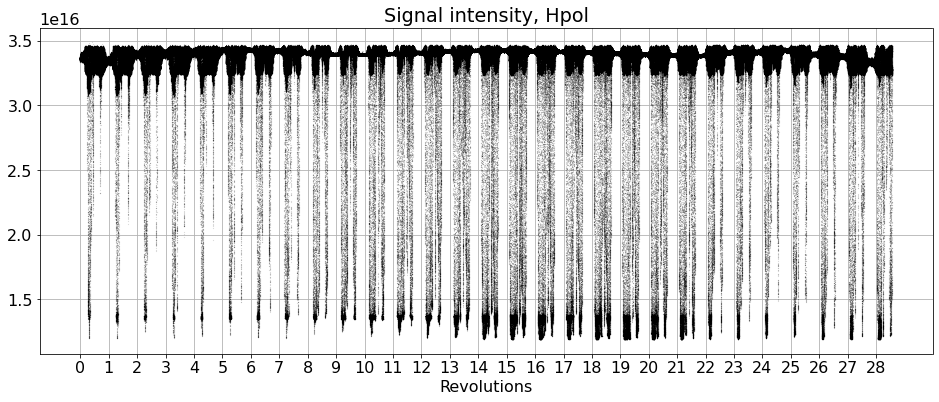

In [18]:
plt.figure(figsize=(16, 6))
plt.plot(revolutions, rho_h, 'k.', ms=0.1)
plt.title('Signal intensity, Hpol')
plt.grid()
plt.xticks(range(29))
plt.xlabel('Revolutions')

Text(0.5, 0, 'Revolutions')

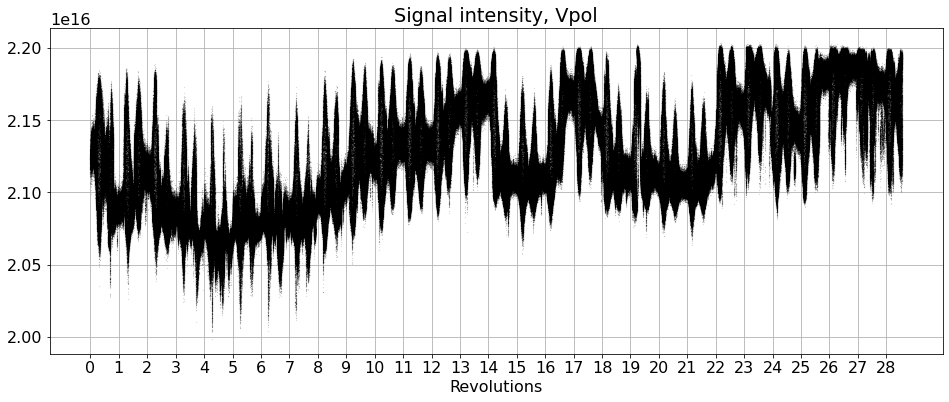

In [19]:
plt.figure(figsize=(16, 6))
plt.plot(revolutions, rho_v, 'k.', ms=0.1)
plt.title('Signal intensity, Vpol')
plt.grid()
plt.xticks(range(29))
plt.xlabel('Revolutions')

Text(0.5, 0, 'Revolutions')

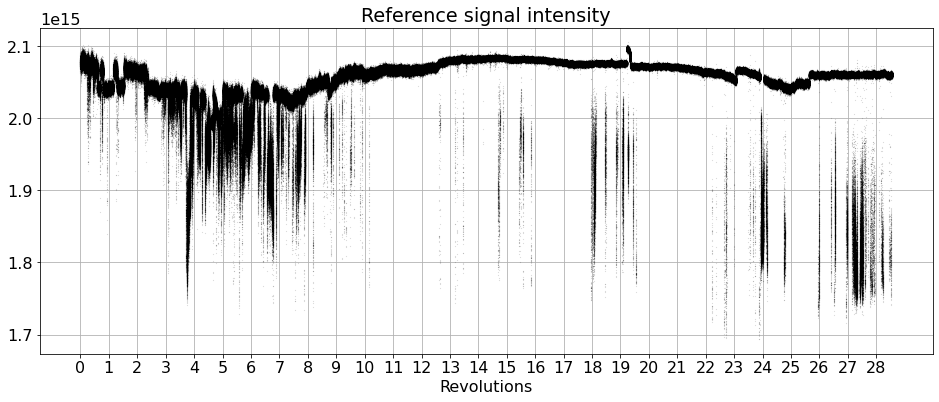

In [20]:
plt.figure(figsize=(16, 6))
plt.plot(revolutions, rho_ref, 'k.', ms=0.1)
plt.title('Reference signal intensity')
plt.grid()
plt.xticks(range(29))
plt.xlabel('Revolutions')

## Signal intensity, normalized by the reference signal

$$
\rho_{n} = (I^2 + Q^2) / R^2
$$

where:

* $R$: Reference signal

Text(0.5, 0, 'Revolutions')

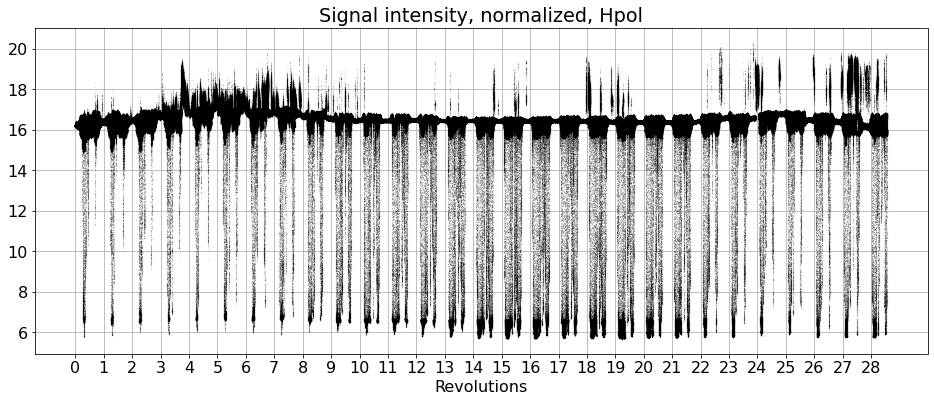

In [21]:
plt.figure(figsize=(16, 6))
plt.plot(revolutions, rho_h / rho_ref, 'k.', ms=0.1)
plt.title('Signal intensity, normalized, Hpol')
plt.grid()
plt.xticks(range(29))
plt.xlabel('Revolutions')

Text(0.5, 0, 'Revolutions')

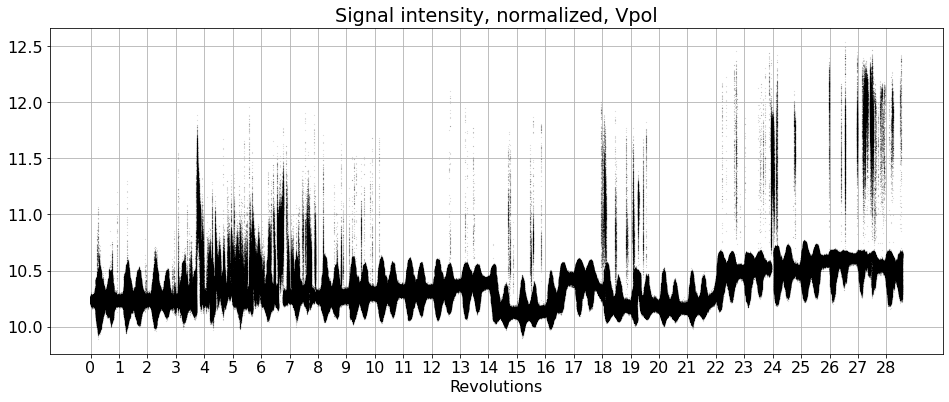

In [22]:
plt.figure(figsize=(16, 6))
plt.plot(revolutions, rho_v / rho_ref, 'k.', ms=0.1)
plt.title('Signal intensity, normalized, Vpol')
plt.grid()
plt.xticks(range(29))
plt.xlabel('Revolutions')

## Zoom in on one ball revolution

In [24]:
def running_mean(x, n):
    """Running mean with the window n."""
    return np.convolve(x, np.ones((n,)) / n, mode='same')

In [43]:
whole_revolutions = range(int(np.min(revolutions)), int(np.max(revolutions)))

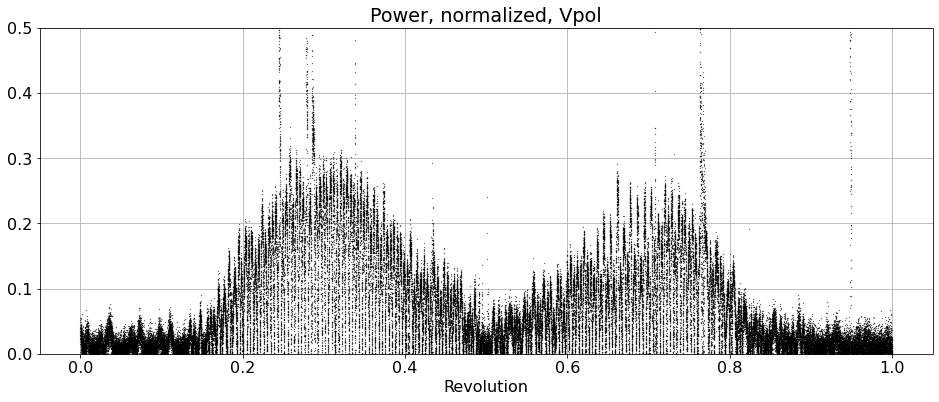

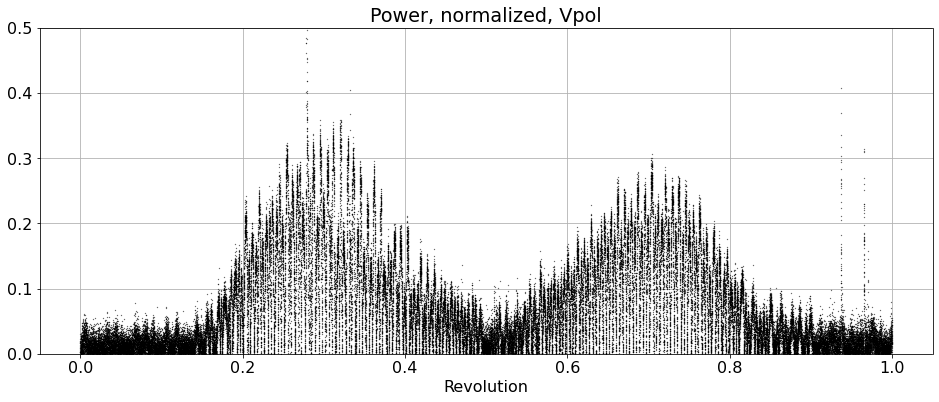

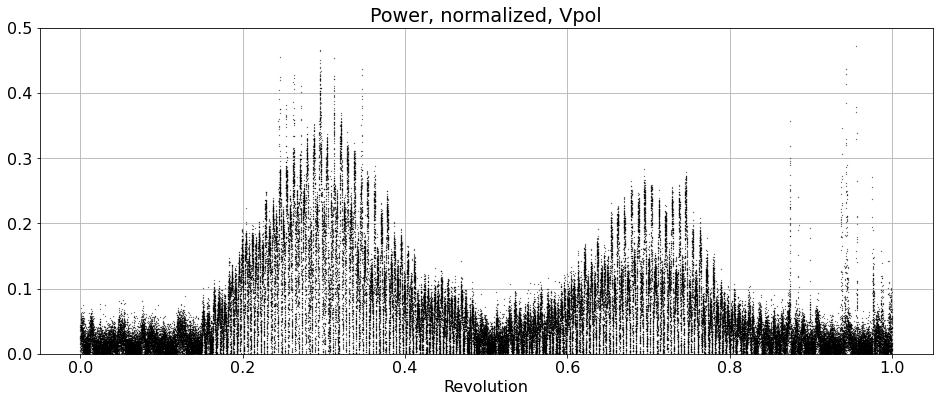

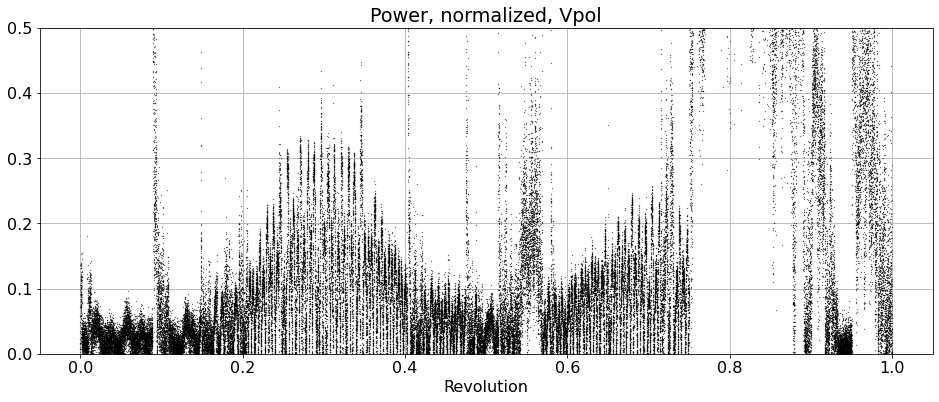

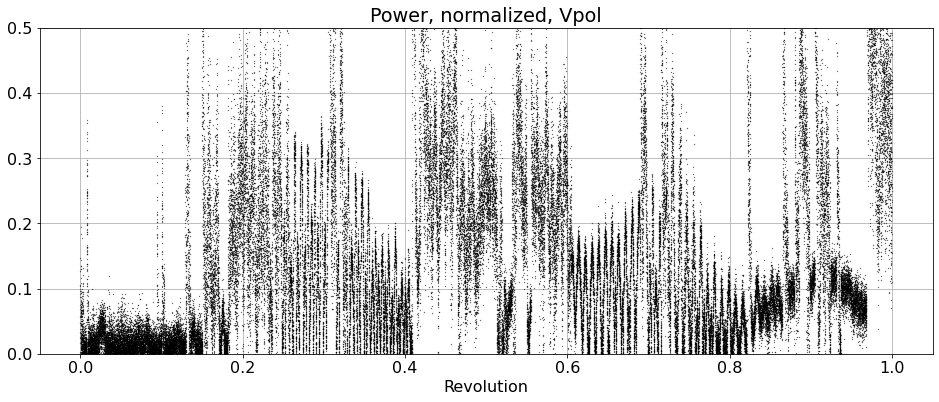

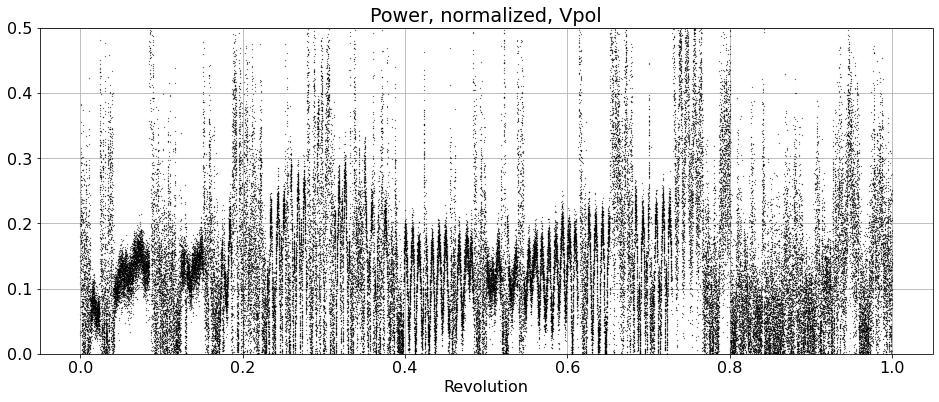

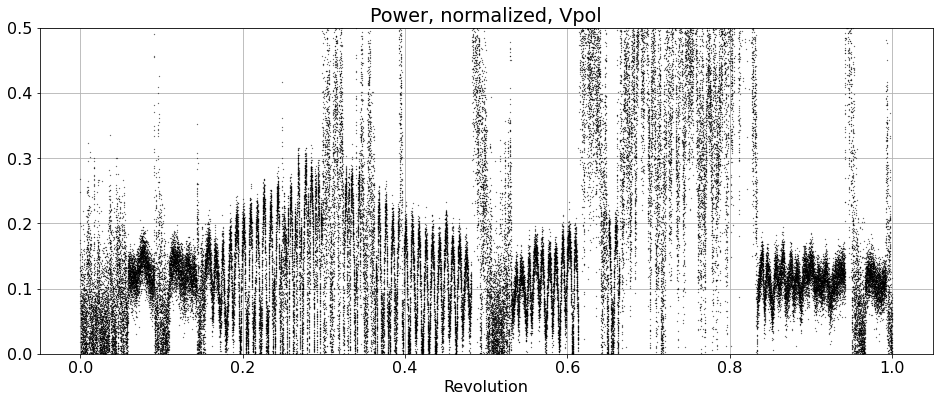

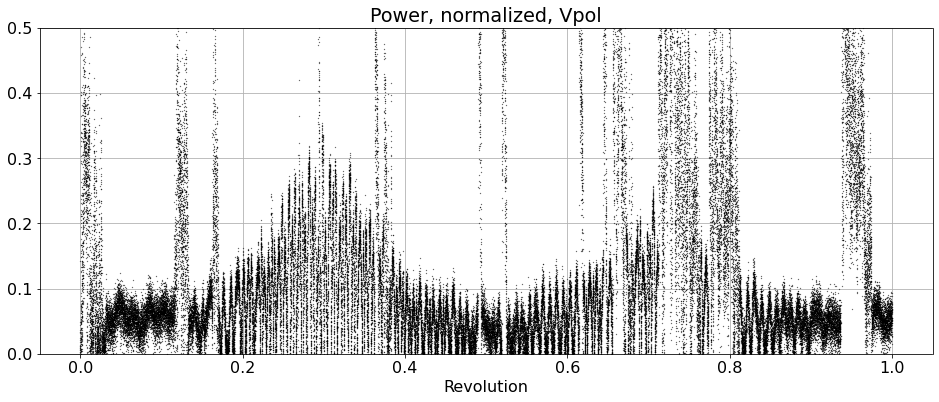

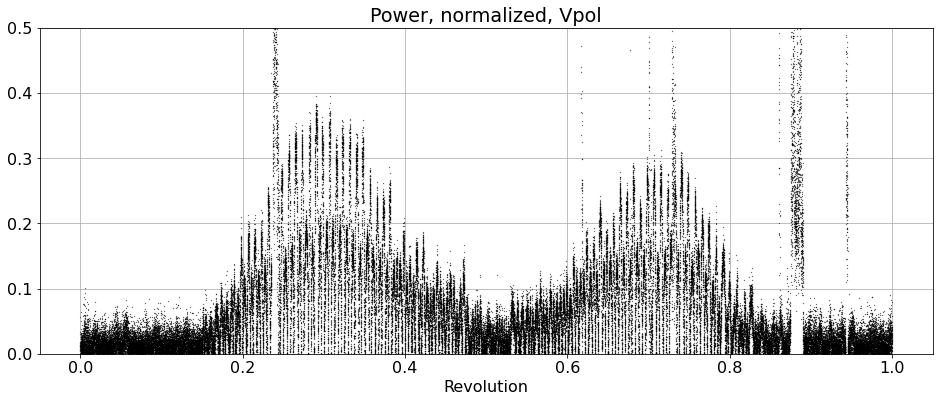

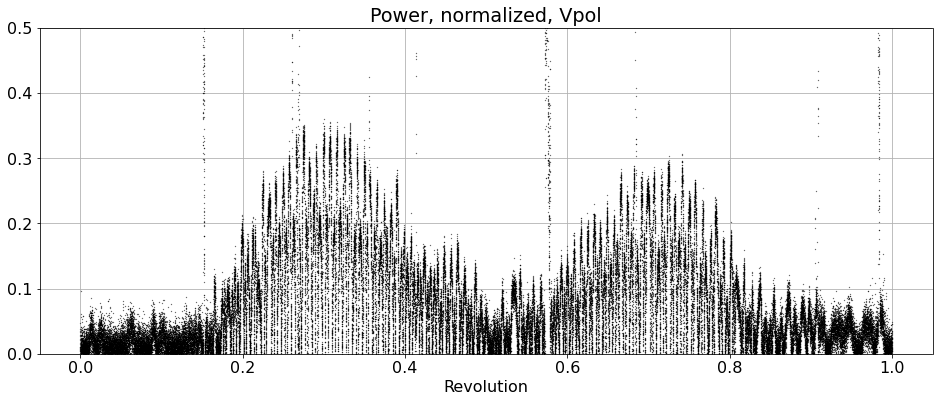

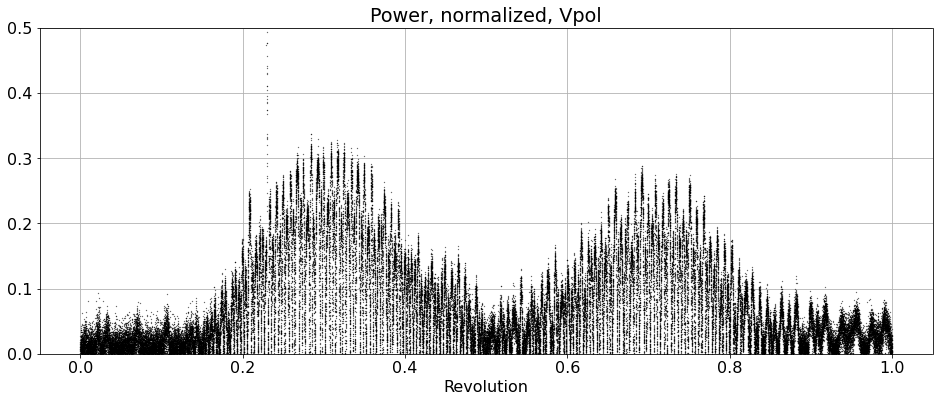

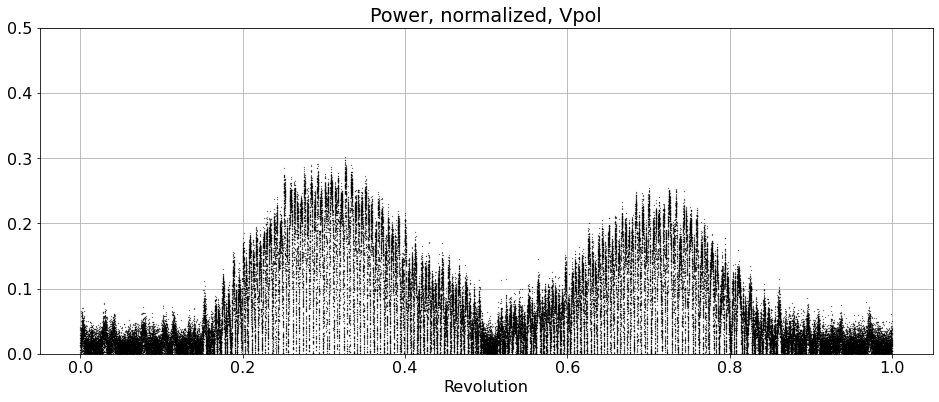

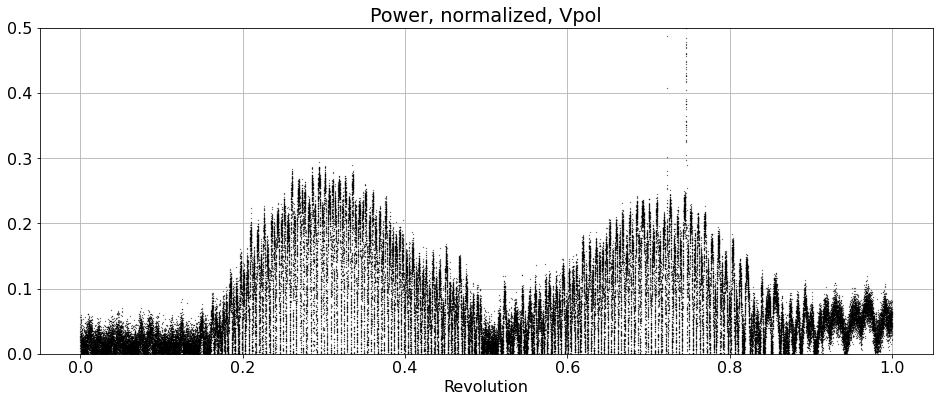

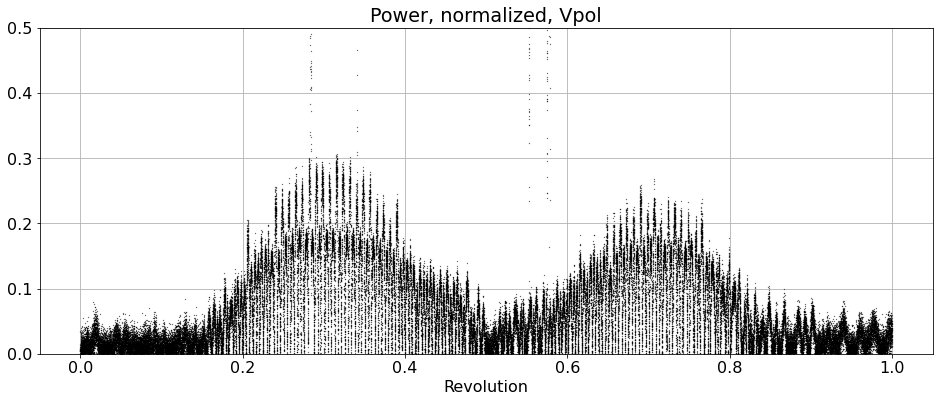

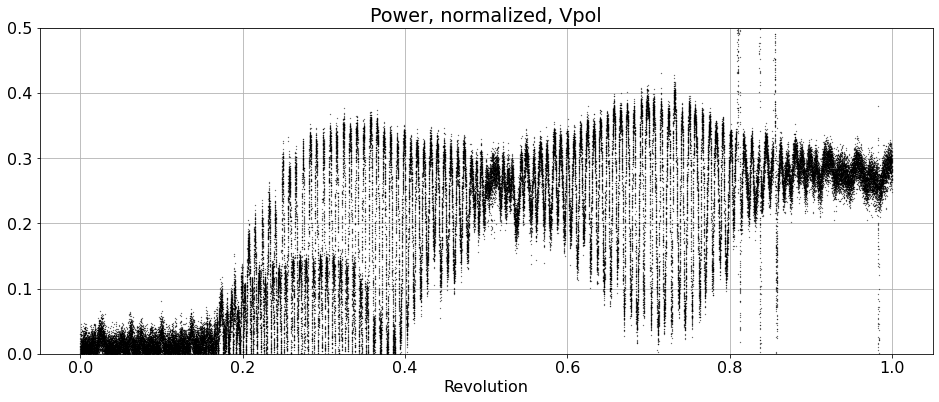

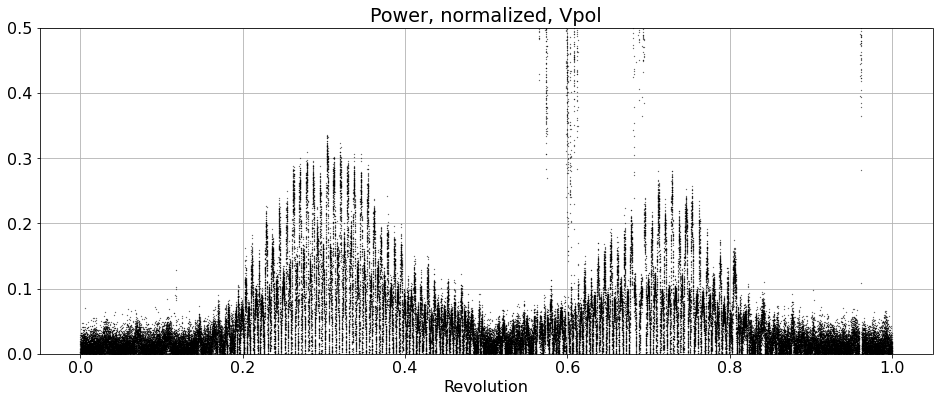

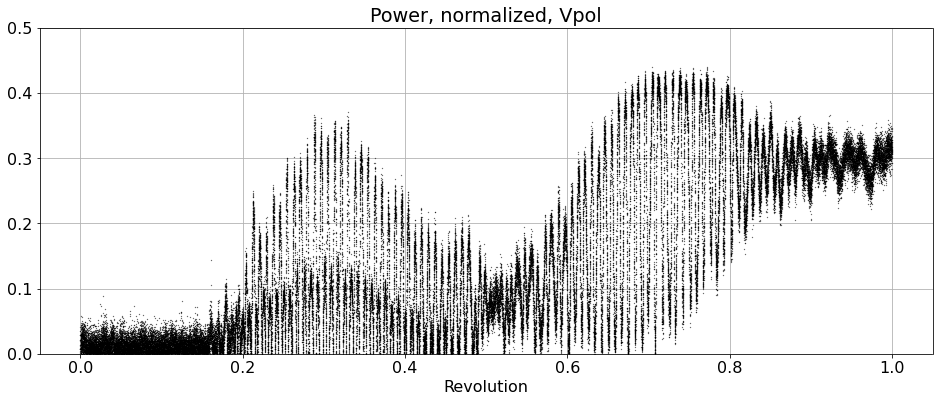

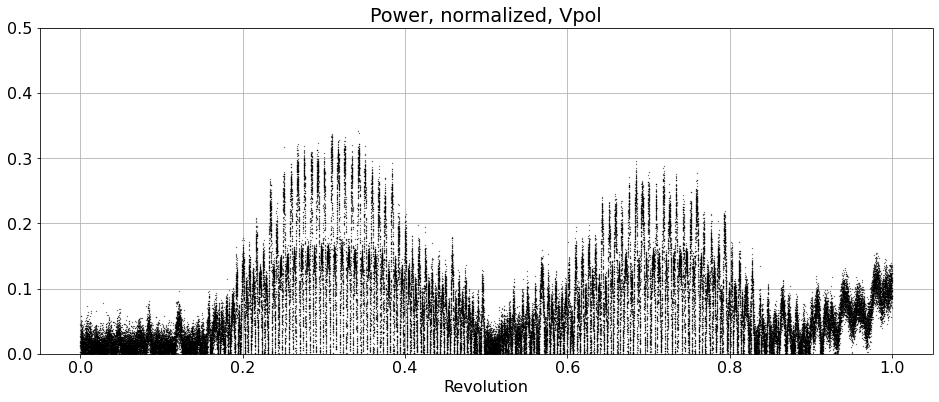

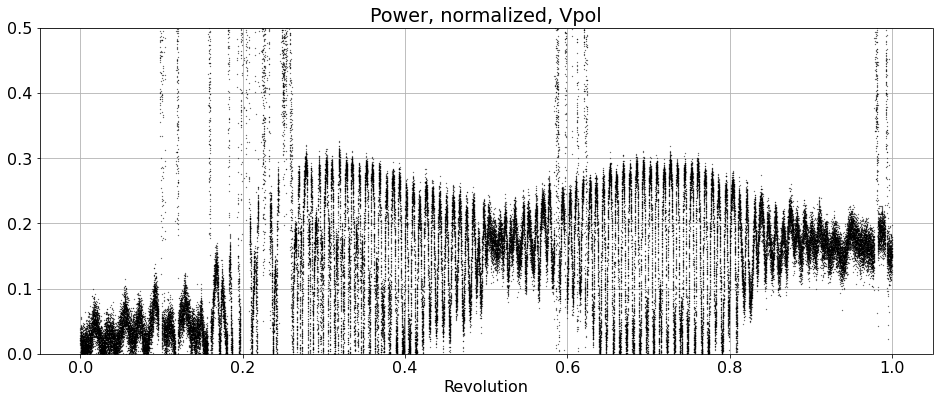

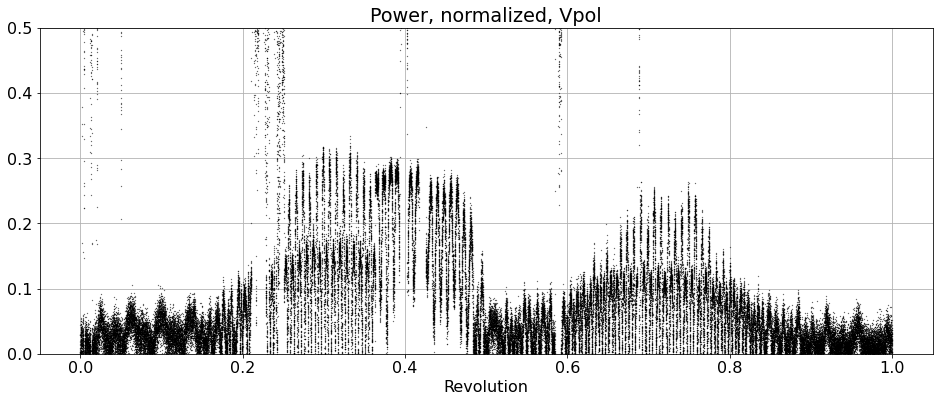

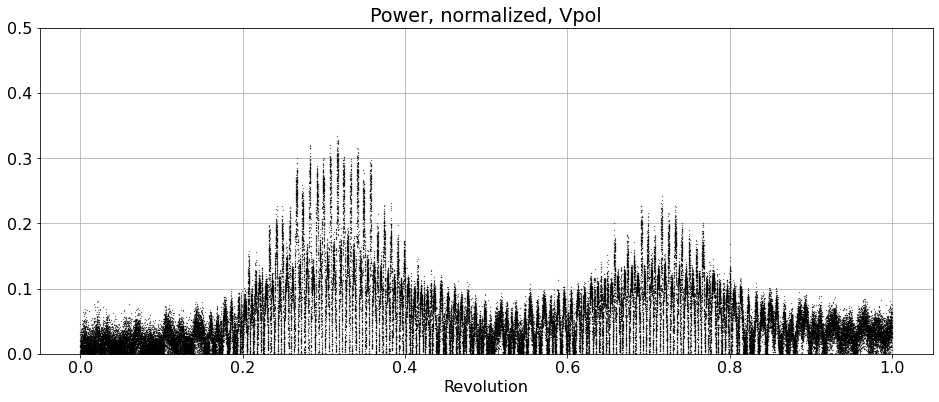

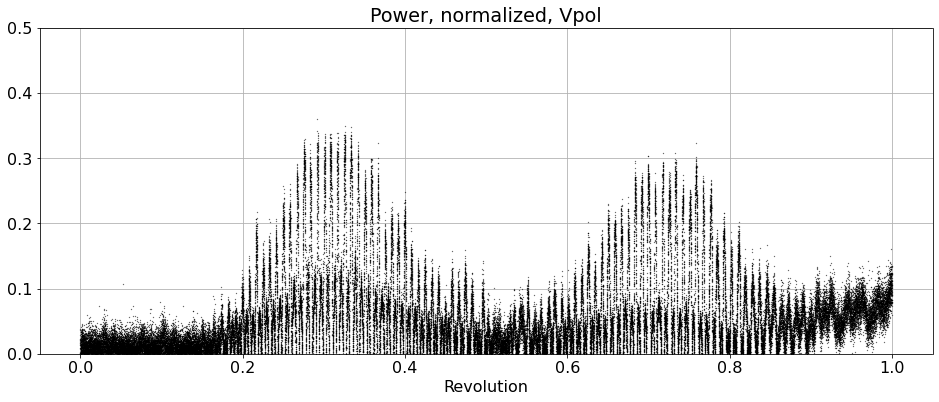

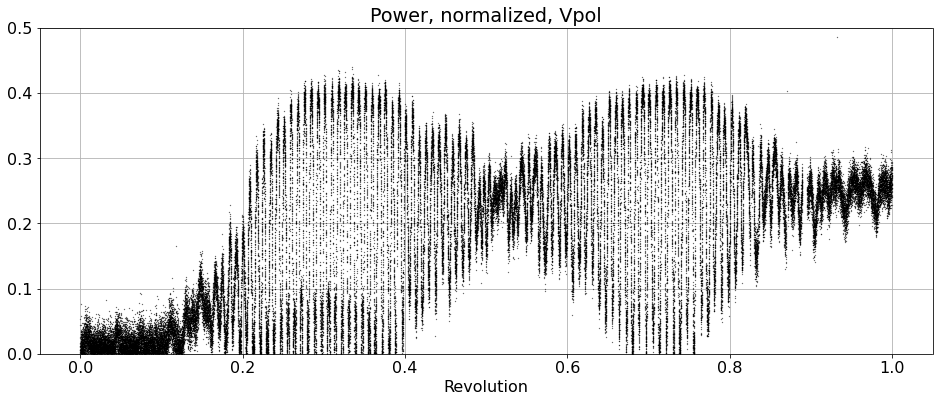

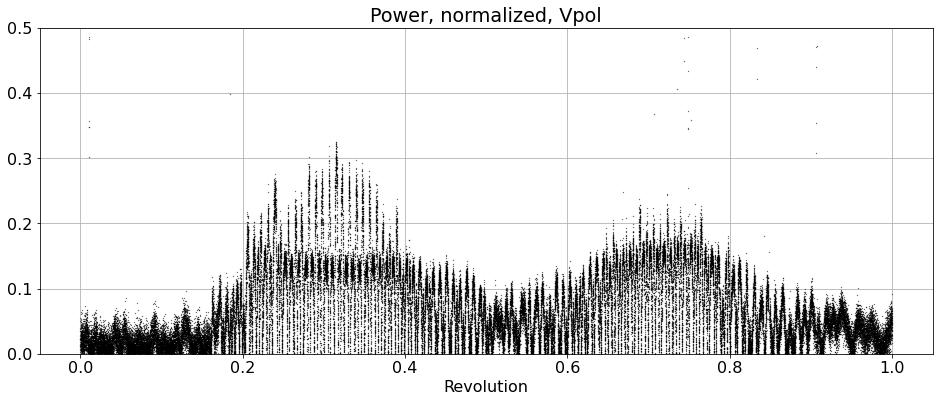

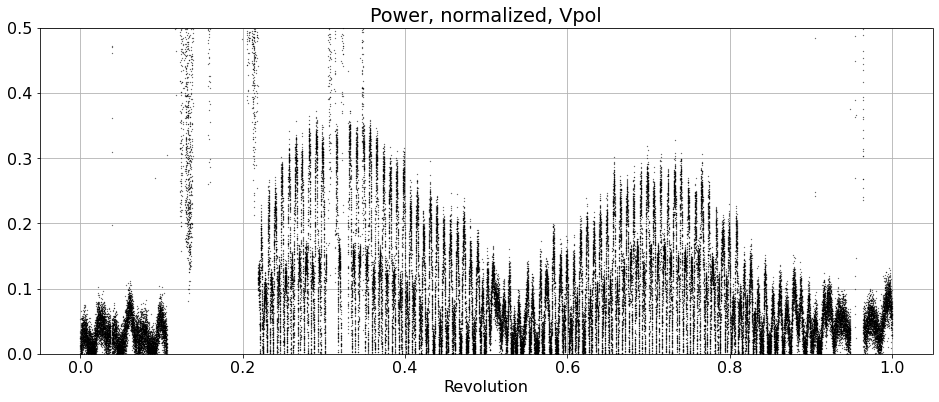

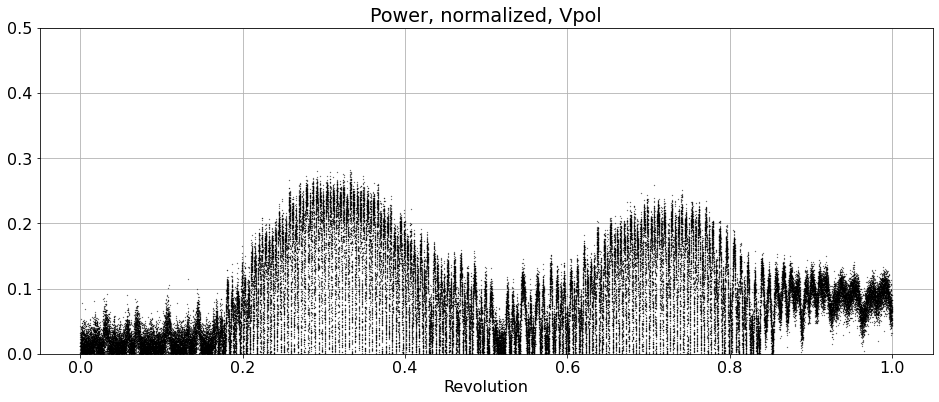

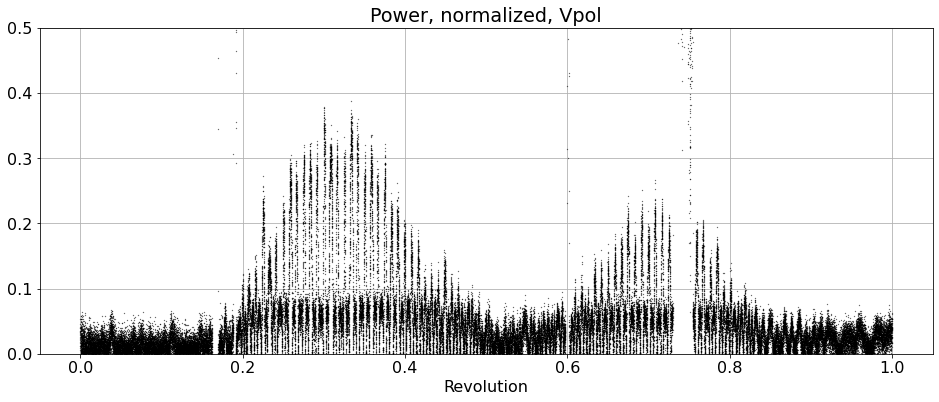

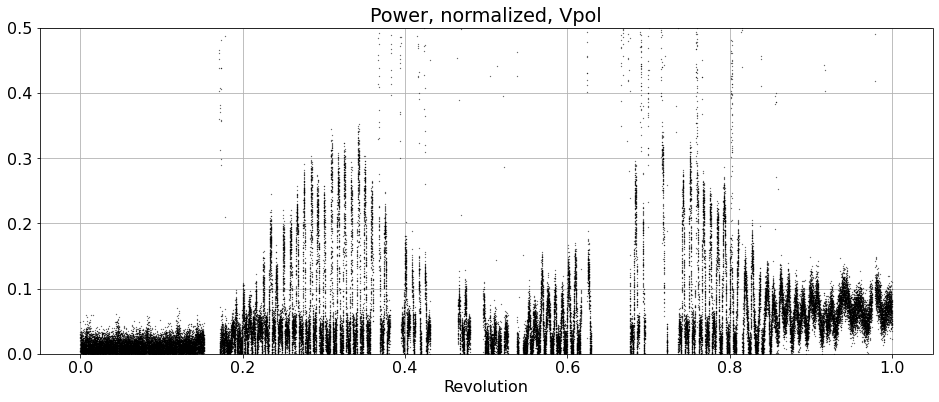

In [63]:
for i in whole_revolutions:
    mask = (revolutions >= i) & (revolutions <= i + 1)
    revolution_time = revolutions[mask] - revolutions[mask][0]
    base_power = np.mean(rho_v_norm[mask][revolution_time < 0.1])
    plt.figure(figsize=(16, 6))
    plt.plot(revolution_time, np.abs(rho_v_norm[mask] - base_power), 'k.', ms=0.5)
    plt.title('Power, normalized, Vpol')
    plt.grid()
    plt.ylim(0, 0.5)
    plt.xlabel('Revolution')
    plt.show()